<a href="https://colab.research.google.com/github/manujism/Nilesh-Client-Simulations/blob/main/with_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preparing data...
Synthesizing monthly returns data. Replace with your actual returns file.
Goal order set chronologically: ['Home Purchase', 'CPL cost', "Elder Daughter's Marriage", "Younger Daughter's Marriage"]
✅ Data preparation complete.

--- Running 2,500 main simulations for 'With Home Purchase' ---

########################################################################################################################
###                                      Detailed Monthly Log for a Single Simulation Path                                       ###
########################################################################################################################
           Date Withdrawal Liquid_Corpus Total_Corpus Debt_Value Flexi Cap Funds_Value Gold_Value Large Cap Index_Value Real Estate_Value Debt_Allocation_% Flexi Cap Funds_Allocation_% Gold_Allocation_% Large Cap Index_Allocation_% Real Estate_Allocation_%
0    2025-06-01       ₹0 L      ₹1.19 Cr     ₹2

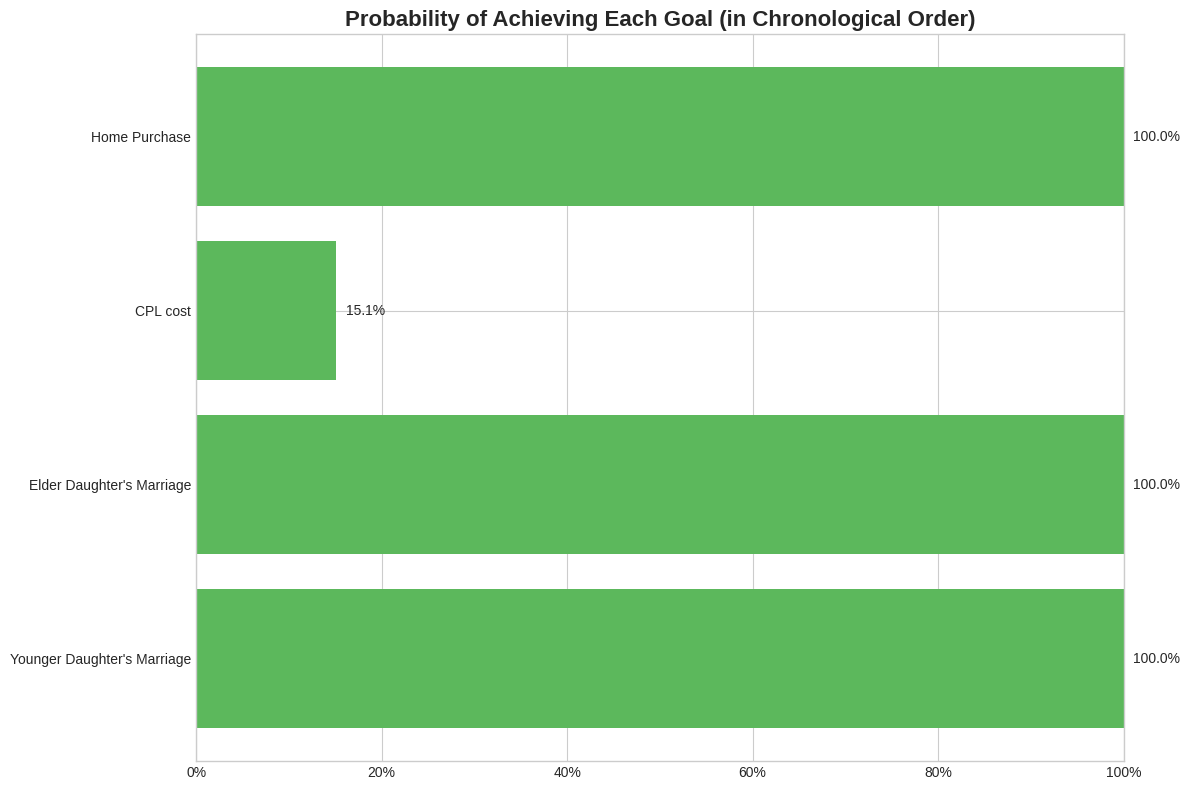

/tmp/ipython-input-1163255133.py:231: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


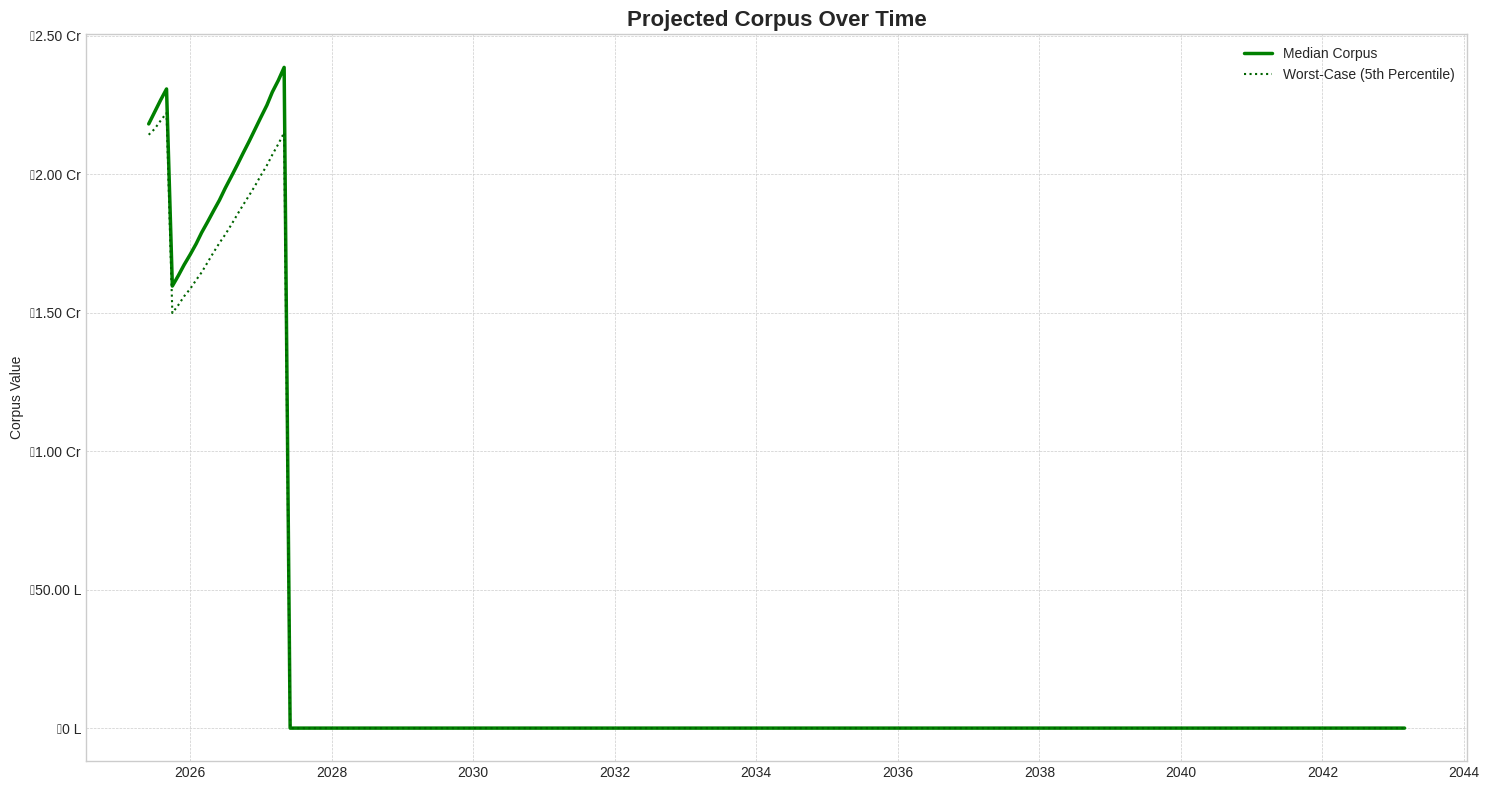

/tmp/ipython-input-1163255133.py:247: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8377 (\N{INDIAN RUPEE SIGN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


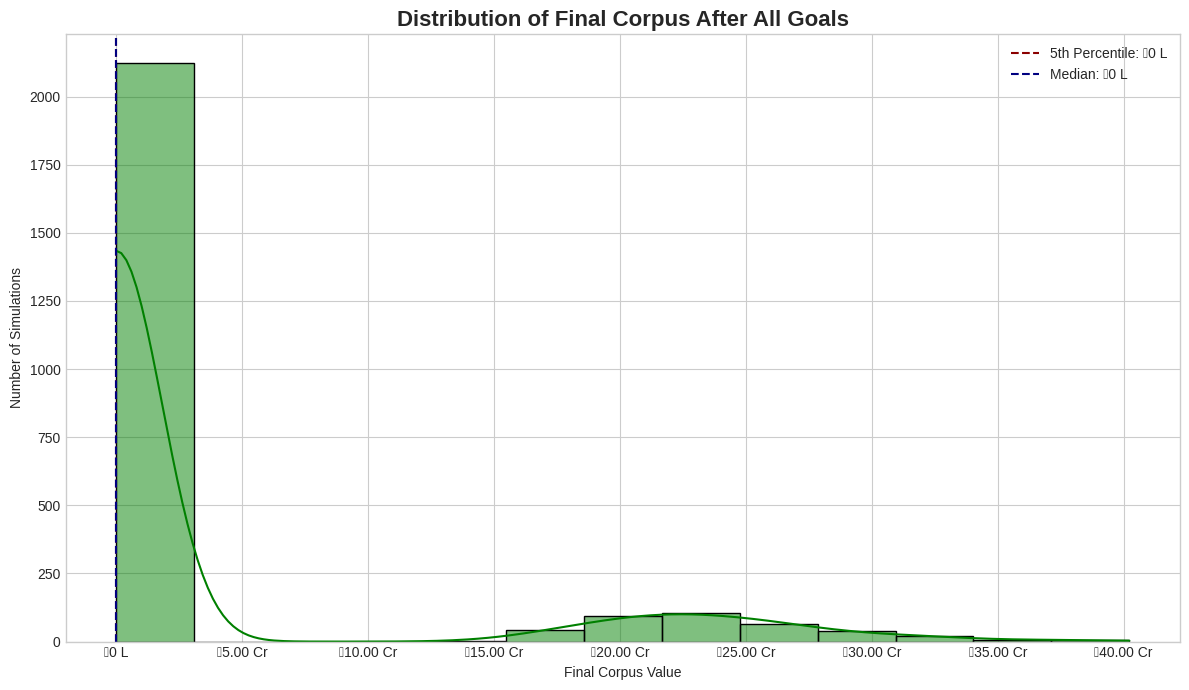


✅ All analyses complete.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from collections import Counter
import io

# --- Helper function for Crores & Lakhs Formatting (No changes) ---
def format_indian_currency(num):
    """Converts a number to a string in Indian Crores/Lakhs format."""
    if pd.isna(num) or num == 0:
        return "₹0 L"
    num = float(num)
    sign = "(-)" if num < 0 else ""
    num = abs(num)

    if num >= 1_00_00_000:
        return f"{sign}₹{num / 1_00_00_000:,.2f} Cr"
    else:
        return f"{sign}₹{num / 1_00_000:,.2f} L"

# --- Function to create a detailed summary DataFrame (No changes) ---
def create_detailed_summary_df(raw_data, dates, goal_df):
    """Creates a detailed month-by-month summary DataFrame from raw simulation data."""
    print("\n--- [Analysis] Generating detailed monthly statistics... ---")
    summary_data = {
        'Median Corpus': np.percentile(raw_data, 50, axis=0),
        'Mean Corpus': np.mean(raw_data, axis=0),
        'Std Dev': np.std(raw_data, axis=0),
        '5th Percentile': np.percentile(raw_data, 5, axis=0),
        '95th Percentile': np.percentile(raw_data, 95, axis=0),
        'Prob. Corpus > 0': np.mean(raw_data > 0, axis=0),
        'Withdrawals': goal_df.sum(axis=1).values
    }
    summary_df = pd.DataFrame(summary_data, index=dates)
    summary_df.index.name = "Month"
    display_summary_df = summary_df.copy()
    currency_cols = ['Median Corpus', 'Mean Corpus', 'Std Dev', '5th Percentile', '95th Percentile', 'Withdrawals']
    for col in currency_cols:
        display_summary_df[col] = display_summary_df[col].apply(format_indian_currency)
    display_summary_df['Prob. Corpus > 0'] = display_summary_df['Prob. Corpus > 0'].apply(lambda p: f"{p:.1%}")
    return summary_df, display_summary_df

# --- Monte Carlo Simulation Engine (MODIFIED) ---
def run_simulation(name, initial_corpus_weights, sip_weights, initial_investment, sip_schedule, goal_df, returns_df, num_simulations, dates):
    """Runs a full, multi-path simulation and prints a detailed log for one simulation."""
    print(f"\n--- Running {num_simulations:,} main simulations for '{name}' ---")
    investment_horizon_months = len(sip_schedule)
    goal_columns = goal_df.columns
    all_assets = sorted(list(set(initial_corpus_weights.keys()) | set(sip_weights.keys())))
    corpus_over_time_all_sims = np.zeros((num_simulations, investment_horizon_months))
    final_corpus_values = []
    goal_failure_counter = Counter()
    liquidity_failures = 0
    detailed_log_for_sim_1 = []

    for i in range(num_simulations):
        corpus_by_asset = {asset: initial_investment * initial_corpus_weights.get(asset, 0) for asset in all_assets}
        has_failed_this_sim = False  # MODIFIED: Flag to track failure state within one simulation path

        for month in range(investment_horizon_months):
            # --- 1. Calculate current state before any actions ---
            sip_this_month = sip_schedule[month]
            real_estate_corpus = corpus_by_asset.get('Real Estate', 0)
            total_corpus_before_actions = sum(corpus_by_asset.values())
            liquid_corpus = total_corpus_before_actions - real_estate_corpus
            withdrawal_amount = goal_df.iloc[month].sum()

            # --- Capture values for logging before they are potentially zeroed out ---
            liquid_corpus_for_log = liquid_corpus

            # --- 2. Check for and handle liquidity failure ---
            # A failure occurs if withdrawals are needed but the liquid corpus is insufficient.
            # We only want to trigger the failure state once per simulation.
            if not has_failed_this_sim and withdrawal_amount > liquid_corpus:
                missed_goals = [goal for goal in goal_columns if goal_df.iloc[month][goal] > 0]
                goal_failure_counter.update(missed_goals)
                liquidity_failures += 1
                has_failed_this_sim = True

            # --- 3. Process withdrawals, SIPs, and returns ---
            # If the simulation has failed, the corpus is wiped out. No further actions occur.
            if has_failed_this_sim:
                for asset in corpus_by_asset:
                    corpus_by_asset[asset] = 0
            else:
                # A. Process withdrawals (proportionally from liquid assets)
                if withdrawal_amount > 0 and liquid_corpus > 0:
                    reduction_factor = (liquid_corpus - withdrawal_amount) / liquid_corpus
                    for asset in corpus_by_asset:
                        if asset != 'Real Estate':
                            corpus_by_asset[asset] *= reduction_factor

                # B. Add SIP contributions
                if sip_this_month > 0:
                    for asset, weight in sip_weights.items():
                        corpus_by_asset[asset] = corpus_by_asset.get(asset, 0) + (sip_this_month * weight)

                # C. Apply monthly returns
                random_returns_row = returns_df.sample(1).iloc[0]
                for asset in corpus_by_asset:
                    asset_return = random_returns_row.get(asset, 0)
                    corpus_by_asset[asset] *= (1 + asset_return / 100.0)

            # --- 4. Log detailed data for the first simulation path (i == 0) ---
            # MODIFIED: This now logs every month, regardless of failure, showing the corpus going to zero.
            if i == 0:
                total_corpus_after_actions = sum(corpus_by_asset.values())
                log_entry = {
                    'Date': dates.iloc[month].strftime('%Y-%m-%d'),
                    'Withdrawal': withdrawal_amount,  # ADDED: Log the withdrawal amount
                    'Liquid_Corpus': liquid_corpus_for_log, # Use the value before potential failure wipeout
                    'Total_Corpus': total_corpus_after_actions
                }

                for asset in all_assets:
                    log_entry[f'{asset}_Value'] = corpus_by_asset.get(asset, 0)

                for asset in all_assets:
                    allocation = (corpus_by_asset.get(asset, 0) / total_corpus_after_actions) * 100 if total_corpus_after_actions > 0 else 0
                    log_entry[f'{asset}_Allocation_%'] = allocation

                detailed_log_for_sim_1.append(log_entry)

            # --- 5. Record the total corpus for this month in the main results array ---
            corpus_over_time_all_sims[i, month] = sum(corpus_by_asset.values())

        final_total_corpus = sum(corpus_by_asset.values())
        final_corpus_values.append(final_total_corpus if final_total_corpus >= 0 else 0)

    # --- Print the refined detailed DataFrame for the single simulation ---
    print("\n" + "#"*120)
    print("###" + " "*38 + "Detailed Monthly Log for a Single Simulation Path" + " "*39 + "###")
    print("#"*120)
    if detailed_log_for_sim_1:
        detailed_df = pd.DataFrame(detailed_log_for_sim_1)
        display_df = detailed_df.copy()

        # MODIFIED: Added 'Withdrawal' to the list of columns to format as currency
        value_cols = [col for col in display_df.columns if '_Value' in col or 'Corpus' in col or 'Withdrawal' in col]
        for col in value_cols:
            display_df[col] = display_df[col].apply(format_indian_currency)

        alloc_cols = [col for col in display_df.columns if '_Allocation_%' in col]
        for col in alloc_cols:
            display_df[col] = display_df[col].apply(lambda x: f"{x:.2f}%")

        # MODIFIED: Added 'Withdrawal' to the ordered list for display
        ordered_cols = ['Date', 'Withdrawal', 'Liquid_Corpus', 'Total_Corpus']
        for asset in all_assets:
            ordered_cols.append(f'{asset}_Value')
        for asset in all_assets:
            ordered_cols.append(f'{asset}_Allocation_%')

        display_df = display_df[ordered_cols]

        pd.set_option('display.max_rows', None)        # show all rows
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 2500)
        print(display_df)
        pd.reset_option('display.max_rows')
        pd.reset_option('display.max_columns')
        pd.reset_option('display.width')

    else:
        print("No data logged for the detailed simulation view.")

    # --- Save full simulations DataFrame to CSV (without printing it) ---
    all_sims_df = pd.DataFrame(
        corpus_over_time_all_sims.T,
        index=dates,
        columns=[f"Simulation_{i+1}" for i in range(num_simulations)]
    )
    all_sims_df.index.name = "Month"
    all_sims_df.to_csv("full_simulation_paths.csv")
    print("\n✅ Full simulation paths with raw data saved to 'full_simulation_paths.csv'")

    prob_all_goals = 1 - (liquidity_failures / num_simulations)
    goal_success_prob = {goal: 1 - (goal_failure_counter.get(goal, 0) / num_simulations) for goal in goal_columns if goal_df[goal].sum() > 0}

    return {
        'name': name,
        'prob_all_goals': prob_all_goals,
        'median_corpus': np.median(final_corpus_values),
        '5th_percentile_corpus': np.percentile(final_corpus_values, 5),
        'final_corpus_values': final_corpus_values,
        'goal_success_prob': goal_success_prob,
        'corpus_over_time_median': np.percentile(corpus_over_time_all_sims, 50, axis=0),
        'corpus_over_time_p5': np.percentile(corpus_over_time_all_sims, 5, axis=0),
        'raw_corpus_data': corpus_over_time_all_sims
    }

# --- Visualization Functions (No changes) ---
def plot_goal_probabilities(ordered_goal_probs):
    """Plots goal success probabilities as a horizontal bar chart."""
    plt.style.use('seaborn-v0_8-whitegrid')
    if not ordered_goal_probs:
        print("No goals with withdrawals found to plot.")
        return

    goals = [g.replace('Goal: ', '') for g in ordered_goal_probs.keys()]
    probs = list(ordered_goal_probs.values())

    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.barh(goals, probs, color='#5cb85c')

    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0%}'))
    ax.set_title('Probability of Achieving Each Goal (in Chronological Order)', fontsize=16, weight='bold')

    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.1%}', ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_corpus_projections(results, goal_df, dates):
    plt.figure(figsize=(15, 8))
    median_line = results['corpus_over_time_median']
    p5_line = results['corpus_over_time_p5']
    plt.plot(dates, median_line, label="Median Corpus", color='green', linewidth=2.5)
    plt.plot(dates, p5_line, label="Worst-Case (5th Percentile)", color='darkgreen', linestyle=':')
    plt.title('Projected Corpus Over Time', fontsize=16, weight='bold')
    plt.ylabel('Corpus Value')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_indian_currency(y)))
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_final_corpus_distribution(results):
    plt.figure(figsize=(12, 7))
    final_values = results['final_corpus_values']
    plt.title('Distribution of Final Corpus After All Goals', fontsize=16, weight='bold')
    plt.xlabel('Final Corpus Value')
    plt.ylabel('Number of Simulations')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_indian_currency(x)))
    sns.histplot(data=final_values, kde=True, fill=True, color='green')
    median_val = results['median_corpus']
    p5_val = results['5th_percentile_corpus']
    plt.axvline(p5_val, color='darkred', linestyle='--', linewidth=1.5, label=f'5th Percentile: {format_indian_currency(p5_val)}')
    plt.axvline(median_val, color='navy', linestyle='--', linewidth=1.5, label=f'Median: {format_indian_currency(median_val)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Main Execution Block (No changes) ---
def main():
    CLIENT_DATA_FILE = 'Nilesh M. Concise Data - Buy Home.xlsx'
    CLIENT_DATA_SHEET = 'With Home Purchase'
    try:
        print("Loading and preparing data...")
        client_data_df = pd.read_excel(CLIENT_DATA_FILE, sheet_name=CLIENT_DATA_SHEET)

        print("Synthesizing monthly returns data. Replace with your actual returns file.")
        returns_data = {
            'Debt': np.random.normal(0.6, 1.0, 240),
            'Gold': np.random.normal(0.8, 3.0, 240),
            'Real Estate': np.random.normal(1.0, 2.5, 240),
            'Large Cap Index': np.random.normal(1.2, 4.0, 240),
            'Flexi Cap Funds': np.random.normal(1.2, 4.0, 240)
        }
        returns_df = pd.DataFrame(returns_data)
        returns_df.columns = returns_df.columns.str.strip()

        client_data_df['Month'] = pd.to_datetime(client_data_df['Month'])
        dates = client_data_df['Month']
        sip_schedule = pd.to_numeric(client_data_df['Total Investment'], errors='coerce').fillna(0).values
        goal_cols = [col for col in client_data_df.columns if 'Goal:' in col]
        goal_df = client_data_df[goal_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

        goal_order = sorted(
            goal_df.columns,
            key=lambda g: goal_df[g].ne(0).idxmax() if goal_df[g].sum() > 0 else pd.Timestamp.max
        )
        goal_df = goal_df[goal_order]
        print(f"Goal order set chronologically: {[g.replace('Goal: ', '') for g in goal_order]}")
        print("✅ Data preparation complete.")

        initial_investment = 21428380
        num_simulations = 2500
        initial_corpus_weights = {
            'Real Estate': 0.4434, 'Debt': 0.3221, 'Flexi Cap Funds': 0.10745,
            'Large Cap Index': 0.10745, 'Gold': 0.0196
        }
        sip_weights = {
            'Flexi Cap Funds': 0.30, 'Large Cap Index': 0.20,
            'Debt': 0.25, 'Gold': 0.25
        }

        results = run_simulation(
            "With Home Purchase", initial_corpus_weights, sip_weights, initial_investment,
            sip_schedule, goal_df, returns_df, num_simulations, dates
        )

        print("\n\n" + "#"*80)
        print("###" + " "*27 + "SIMULATION ANALYSIS" + " "*28 + "###")
        print("#"*80)
        print(f"\nOverall Success Probability (All Goals Met): {results['prob_all_goals']:.1%}")
        print(f"Median Final Corpus (Typical Outcome): {format_indian_currency(results['median_corpus'])}")
        print(f"Worst-Case Corpus (5th Percentile): {format_indian_currency(results['5th_percentile_corpus'])}")

        ordered_goal_probs = {goal: results['goal_success_prob'][goal] for goal in goal_order if goal in results['goal_success_prob']}

        print("\nIndividual Goal Success Probability (Chronological):")
        if ordered_goal_probs:
            for goal, prob in ordered_goal_probs.items():
                print(f"- {goal.replace('Goal: ', '')}: {prob:.1%}")

        raw_summary_df, display_summary_df = create_detailed_summary_df(
            results['raw_corpus_data'], dates, goal_df
        )

        print("\nThis table shows the month-by-month projection of your portfolio's value.")
        print("\n--- Summary Statistics (First 12 Months) ---")
        print(display_summary_df.head(12))
        print("\n--- Summary Statistics (Last 12 Months) ---")
        print(display_summary_df.tail(12))

        SUMMARY_FILE_NAME = 'detailed_monthly_summary.csv'
        raw_summary_df.to_csv(SUMMARY_FILE_NAME)
        print(f"\n✅ Full detailed summary saved to '{SUMMARY_FILE_NAME}'")

        print("\n\n" + "#"*80)
        print("###" + " "*30 + "GENERATING VISUALS" + " "*30 + "###")
        print("#"*80)
        plot_goal_probabilities(ordered_goal_probs)
        plot_corpus_projections(results, goal_df, dates)
        plot_final_corpus_distribution(results)
        print("\n✅ All analyses complete.")

    except FileNotFoundError as e:
        print(f"\n❌ ERROR: Data file not found. Make sure the file '{e.filename}' is in the same directory.")
    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == '__main__':
    main()